In [1]:
from pprint import pprint
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential, activations
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def get_variables_and_size():
    from sys import getsizeof
    names = []
    sizes = []
    types = []
    for name in dir():
        # Print the item if it doesn't start with '__'
        if not name.startswith('__'):
            value = eval(name)
            names.append(name)
            sizes.append(getsizeof(value))
            types.append(type(value))
    sort_indexes = np.argsort(sizes)[::-1]
    names = np.array(names)[sort_indexes]
    sizes = np.array(sizes)[sort_indexes]
    types = np.array(types)[sort_indexes]
    for n,s,t in zip(names,sizes,types):
        print(n, "\n\tsize :", s, "\n\ttype :", t)

In [4]:
def get_normalization_infos(*x_s, columns):
    normalization_infos = pd.DataFrame(data=[[1000 for _ in range(len(columns))],[0 for _ in range(len(columns))]],
                                     index=["min","max"],
                                     columns=columns)
    for x in x_s :
        for col in columns:
            min_value = min(normalization_infos[col]["min"], x[col].min())
            max_value = max(normalization_infos[col]["max"], x[col].max())
            normalization_infos[col] = [min_value, max_value]

    normalization_infos.loc["spread"] = normalization_infos.apply(lambda c : c["max"] - c["min"], axis=0)

    return normalization_infos

def normalize(x : pd.DataFrame, normalization_infos : pd.DataFrame):
    for col in x.columns:
        x[col] = (x[col] - normalization_infos[col]["min"])/normalization_infos[col]["spread"]
    return x

In [5]:
def m_mape(y_true,y_predict):
    n = len(y_true)
    y_true = np.array(y_true) + 1
    y_predict = np.array(y_predict) + 1

    res = ((100/n)*(np.sum(np.abs((y_predict-y_true)/y_true))))
    return res

In [6]:
def box_plot(prediction_df, plot_title = "test set"):
    y_upper_bound = np.mean([prediction_df["ground_truth"].max(), prediction_df["Prediction"].max()])
    mape_score = m_mape(prediction_df["ground_truth"],prediction_df["Prediction"])

    plt.figure(figsize=(20,10))
    plt.suptitle(plot_title)

    plt.subplot(2,3,1)
    plt.title("ground_truth")
    plt.boxplot(prediction_df["ground_truth"])
    plt.ylim([-0.01,y_upper_bound])

    plt.subplot(2,3,2)
    plt.title("Prediction. MAPE : {:.2f}".format(mape_score))
    plt.boxplot(prediction_df["Prediction"])
    plt.ylim([-0.01,y_upper_bound])

    plt.subplot(2,3,3)
    plt.boxplot(prediction_df["reg_pred"])
    plt.title("Regression only. MAPE : {:.2f}".format(m_mape(prediction_df["ground_truth"],prediction_df["reg_pred"])))
    plt.ylim([-0.01, y_upper_bound])

    plt.subplot(2,3,4)
    plt.hist(prediction_df[prediction_df["ground_truth"]<y_upper_bound]["ground_truth"], bins=100)
    plt.xlim([0,y_upper_bound])
    plt.ylim([0,len(prediction_df)])

    plt.subplot(2,3,5)
    plt.hist(prediction_df[prediction_df["Prediction"]<y_upper_bound]["Prediction"], bins=100)
    plt.xlim([0,y_upper_bound])
    plt.ylim([0,len(prediction_df)])

    plt.subplot(2,3,6)
    plt.hist(prediction_df[prediction_df["reg_pred"]<y_upper_bound]["reg_pred"], bins=100)
    plt.xlim([0,y_upper_bound])
    plt.ylim([0,len(prediction_df)])

    plt.show()

In [7]:
# Creating model using the Sequential in tensorflow
def build_model_classf(*layers, loss ='binary_crossentropy', metrics = ("AUC","accuracy"), learning_rate=0.001, last_activation="softmax"):
    model = Sequential()
    model.add(layers[0])
    for layer in layers[1:]:
        model.add(layer)
    model.add(Dense(2, activation=last_activation))

    model.compile(
        loss=loss,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=metrics
    )

    print(model.summary())
    return model

def make_cls_model(*layers,x,y,x_val=None,y_val=None,val_split=0.15, epochs=15, batch_size=64, learning_rate=0.001, last_activation="softmax"):
    # build the model
    model_cls = build_model_classf(*layers, learning_rate=learning_rate, last_activation=last_activation)
    # train the model
    if x_val is None :
        history_cls = model_cls.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split
            # validation_data=(x_test,y_cls_test)
            )
    else :
        history_cls = model_cls.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            # validation_split=0.15
            validation_data=(x_val,y_val)
            )
    return history_cls,model_cls

def plot_history_cls(history, loss, key1, key2):
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])

    plt.subplot(1,3,2)
    plt.title("metric : {}".format(key1))
    plt.plot(history.history[key1])
    plt.plot(history.history['val_'+key1])
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel(key1)
    plt.legend([key1, 'val_'+key1])

    plt.subplot(1,3,3)
    plt.title("metric : {}".format(key2))
    plt.plot(history.history[key2.lower()])
    plt.plot(history.history['val_'+key2.lower()])
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel(key2)
    plt.legend([key2, 'val_'+key2])

    plt.suptitle("Classification results")
    plt.show()

In [8]:
# Creating model using the Sequential in tensorflow
def build_model_regrs(*layers, metric = MeanSquaredError(), learning_rate=0.001, last_activation="relu"):
    model = Sequential()
    model.add(layers[0])
    for layer in layers[1:]:
        model.add(layer)
    model.add(Dense(1, activation=last_activation))

    model.compile(
        loss=metric,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[metric]
    )

    # print(model.summary())
    return model

def make_reg_model(*layers,x,y,x_val=None,y_val=None,val_split=0.15, epochs=15, batch_size=64, learning_rate=0.001, last_activation="relu"):
    # build the model
    model_reg = build_model_regrs(*layers, learning_rate=learning_rate, last_activation=last_activation)
    # train the model
    if x_val is None :
        history_reg = model_reg.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split
            # validation_data=(x_test,y_cls_test)
            )
    else :
        history_reg = model_reg.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            # validation_split=0.15
            validation_data=(x_val,y_val)
            )
    return history_reg,model_reg

def plot_history_reg(history, loss : str):
    plt.figure(figsize=(7,5))
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])
    plt.show()

In [9]:
# custom activation functions
exp_relu = lambda x : activations.exponential(activations.relu(x)) - 1
square_relu = lambda x : activations.relu(x)**2

In [10]:
cluster_month_0 = [11,12,1,2,3,4]
cluster_month_1 = [5,6,7,8,9,10]

# Load the dataset

In [11]:
df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final_by_day.zip")
# df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final.zip")
df_train["raining"] = df_train["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_train["not_raining"] = 1-df_train["raining"]

x_2016, y_reg_2016, y_cls_2016 = df_train, df_train["ground_truth"], df_train[["not_raining","raining"]].to_numpy()
del df_train

In [12]:
df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final_by_day.zip")
# df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final.zip")

df_test["raining"] = df_test["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_test["not_raining"] = 1-df_test["raining"]

x_2017, y_reg_2017, y_cls_2017 = df_test, df_test["ground_truth"], df_test[["not_raining","raining"]].to_numpy()
del df_test

# merge 2016, 2017

In [13]:
x = pd.concat([x_2016,x_2017])
y_cls = np.concatenate([y_cls_2016, y_cls_2017])
y_reg = np.concatenate([y_reg_2016, y_reg_2017])

# split cluster 0 (c0) - cluster 1 (c1)

In [14]:
x["cluster"] = x["month"].apply(lambda x : 0 if x in cluster_month_0 else 1)

In [15]:
x_c0 = x[x["cluster"] == 0]
x_c1 = x[x["cluster"] == 1]

y_cls_c0 = y_cls[x["cluster"] == 0]
y_cls_c1 = y_cls[x["cluster"] == 1]

y_reg_c0 = y_reg[x["cluster"] == 0]
y_reg_c1 = y_reg[x["cluster"] == 1]

# train test split

In [16]:
x_train_c0, x_test_c0, y_cls_train_c0, y_cls_test_c0, y_reg_train_c0, y_reg_test_c0 = train_test_split(x_c0,y_cls_c0,y_reg_c0, test_size=0.1,random_state=42)
x_train_c1, x_test_c1, y_cls_train_c1, y_cls_test_c1, y_reg_train_c1, y_reg_test_c1 = train_test_split(x_c1,y_cls_c1,y_reg_c1, test_size=0.1,random_state=42)

In [17]:
# get rows for computing MAPE on test
prediction_x_test_c0 = pd.DataFrame(x_test_c0[["Id","ground_truth", "month"]])
prediction_x_test_c1 = pd.DataFrame(x_test_c1[["Id","ground_truth", "month"]])

# drop unnecessary columns

In [18]:
# define the unnecessary columns
cols_to_drop = {"day","Id", "station_id","month","longitude_idx","latitude_idx", "next hour precipitation (kg/m^2)", "wind_direction (deg)", "ground_truth","not_raining","raining", "cluster"}

In [19]:
#drop unnecessary columns
x_train_c0.drop(list(set(x_train_c0.columns)&cols_to_drop), axis=1, inplace=True)
x_train_c1.drop(list(set(x_train_c1.columns)&cols_to_drop), axis=1, inplace=True)

In [20]:
#drop unnecessary columns
x_test_c0.drop(list(set(x_test_c0.columns)&cols_to_drop), axis=1, inplace=True)
x_test_c1.drop(list(set(x_test_c1.columns)&cols_to_drop), axis=1, inplace=True)


# get same columns on both datasets

In [21]:
columns = list(x_train_c0.columns)
x_train_c0 = x_train_c0[columns]
x_test_c0 = x_test_c0[columns]
x_train_c1 = x_train_c1[columns]
x_test_c1 = x_test_c1[columns]

# normalize both dataset with 2016 min and min-max values

In [22]:
normalization_infos = get_normalization_infos(x_train_c0, x_test_c0, x_train_c1, x_test_c1, columns=columns)
x_train_c0 = normalize(x_train_c0, normalization_infos)
x_test_c0 = normalize(x_test_c0, normalization_infos)
x_train_c1 = normalize(x_train_c1, normalization_infos)
x_test_c1 = normalize(x_test_c1, normalization_infos)

# see if the data is balanced raining-wise

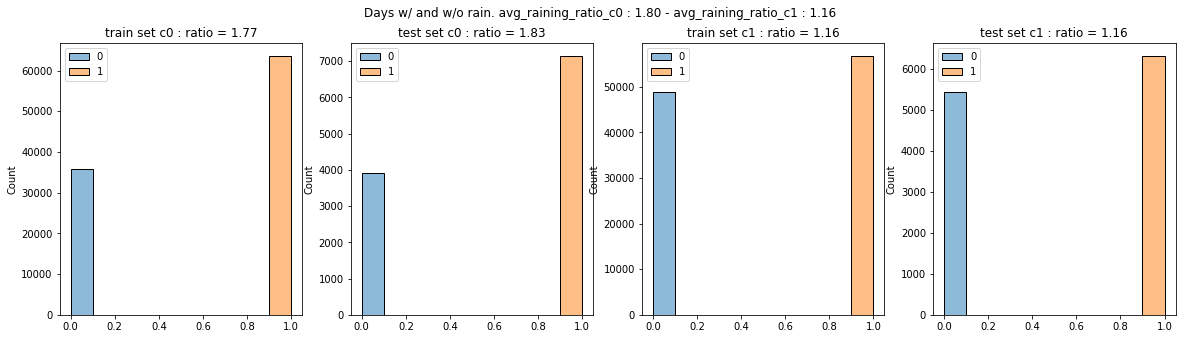

In [23]:
raining_ratio1_c0 = y_cls_train_c0[:,1].sum()/y_cls_train_c0[:,0].sum()
raining_ratio2_c0 = y_cls_test_c0[:,1].sum()/y_cls_test_c0[:,0].sum()
raining_ratio1_c1 = y_cls_train_c1[:,1].sum()/y_cls_train_c1[:,0].sum()
raining_ratio2_c1 = y_cls_test_c1[:,1].sum()/y_cls_test_c1[:,0].sum()
avg_raining_ratio_c0 = (raining_ratio1_c0+raining_ratio2_c0)/2
avg_raining_ratio_c1 = (raining_ratio1_c1+raining_ratio2_c1)/2

plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
sns.histplot(x=y_cls_train_c0[:,1],hue=y_cls_train_c0[:,1], bins=10)
plt.title("train set c0 : ratio = {:.2f}".format(raining_ratio1_c0))
plt.subplot(1,4,2)
sns.histplot(x=y_cls_test_c0[:,1], hue=y_cls_test_c0[:,1], bins=10)
plt.title("test set c0 : ratio = {:.2f}".format(raining_ratio2_c0))
plt.subplot(1,4,3)
sns.histplot(x=y_cls_train_c1[:,1],hue=y_cls_train_c1[:,1], bins=10)
plt.title("train set c1 : ratio = {:.2f}".format(raining_ratio1_c1))
plt.subplot(1,4,4)
sns.histplot(x=y_cls_test_c1[:,1], hue=y_cls_test_c1[:,1], bins=10)
plt.title("test set c1 : ratio = {:.2f}".format(raining_ratio2_c1))
plt.suptitle("Days w/ and w/o rain. avg_raining_ratio_c0 : {:.2f} - avg_raining_ratio_c1 : {:.2f}".format(avg_raining_ratio_c0, avg_raining_ratio_c1))
plt.show()

c0 ==> **Unbalanced**
C1 ==> nearly banalced

------------------------------------------------------------------------------------------
# **cluster 0**
------------------------------------------------------------------------------------------

# Classification Model (raining or not)
source : https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

In [25]:
with tf.device("cpu"):
    history_cls_c0, model_cls_c0 = make_cls_model(
        Dense(128, activation="sigmoid",input_dim=x_train_c0.shape[1]),
        Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        last_activation="sigmoid",
        x=x_train_c0.values ,y=y_cls_train_c0,
        epochs=600,
        batch_size=64,
        learning_rate=0.001
    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               12544     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)               

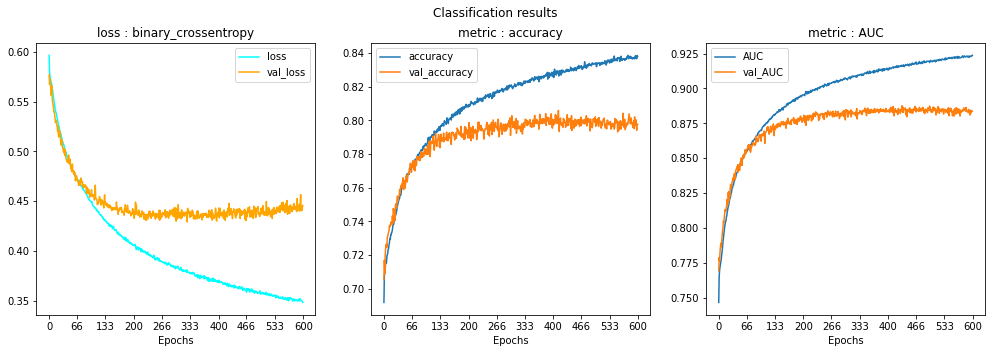

In [26]:
# Plot history
plot_history_cls(history_cls_c0, loss = "binary_crossentropy", key1 = 'accuracy', key2 = 'AUC')

# Regression Model (how much rain if > 0)
source : https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [27]:
# reshape x_train and x_test
# x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
with tf.device("cpu") :
    history_reg_c0, model_reg_c0 = make_reg_model(
        Dense(128, activation="sigmoid",input_dim=x_train_c0.shape[1]),
        Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        last_activation=square_relu,
        x=x_train_c0.values ,y=y_reg_train_c0,
        epochs=600,
        batch_size=64,
        learning_rate=0.001
    )

Epoch 1/600
1321/1321 [==============================] - 3s 2ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0305 - val_mean_squared_error: 0.0306
Epoch 2/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0297 - val_mean_squared_error: 0.0298
Epoch 3/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0287 - val_mean_squared_error: 0.0288
Epoch 4/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 5/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 6/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0283 - val_mean_squared_error: 0.0284
Epoch 7/60

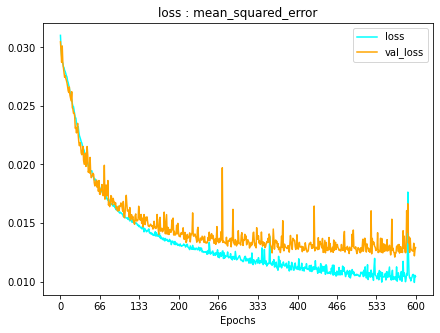

In [28]:
# Plot history
plot_history_reg(history_reg_c0, 'mean_squared_error')

# Compute MAPE on test set

## classification

In [29]:
y_cls_pred_c0 = model_cls_c0.predict(x_test_c0)

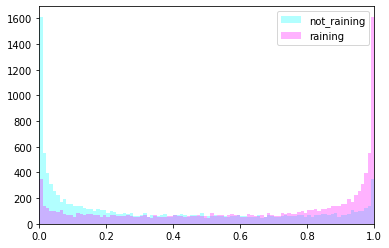

In [30]:
plt.hist(y_cls_pred_c0[:,0], color="cyan", alpha=0.3, bins=100, label="not_raining")
plt.hist(y_cls_pred_c0[:,1], color="magenta", alpha=0.3, bins=100, label="raining")
plt.xlim([0,1])
plt.legend()
plt.show()

In [31]:
y_cls_pred_bkp_c0 = np.array(y_cls_pred_c0)

In [32]:
y_cls_pred_c0 = np.array(y_cls_pred_bkp_c0)

In [33]:
cls_temp_c0 = y_cls_pred_c0[:,0] < y_cls_pred_c0[:,1]
y_cls_pred_c0 = np.array([0 if c else 1 for c in cls_temp_c0])

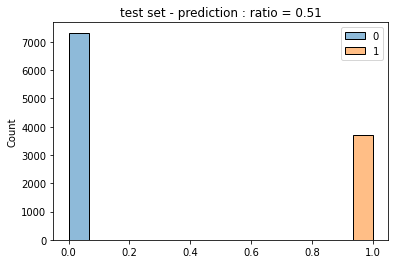

In [34]:
raining_ratio_pred_c0 = y_cls_pred_c0.sum()/(len(y_cls_pred_c0) - y_cls_pred_c0.sum())
plt.title("test set - prediction : ratio = {:.2f}".format(raining_ratio_pred_c0))
sns.histplot(x=y_cls_pred_c0,hue=y_cls_pred_c0)
plt.show()

## regression

In [35]:
y_reg_pred_c0 = model_reg_c0.predict(x_test_c0)

## merge

In [36]:
prediction_x_test_c0["reg_pred"] = y_reg_pred_c0
prediction_x_test_c0["cls_pred"] = y_cls_pred_c0
prediction_x_test_c0["Prediction"] = prediction_x_test_c0["reg_pred"] * prediction_x_test_c0["cls_pred"]

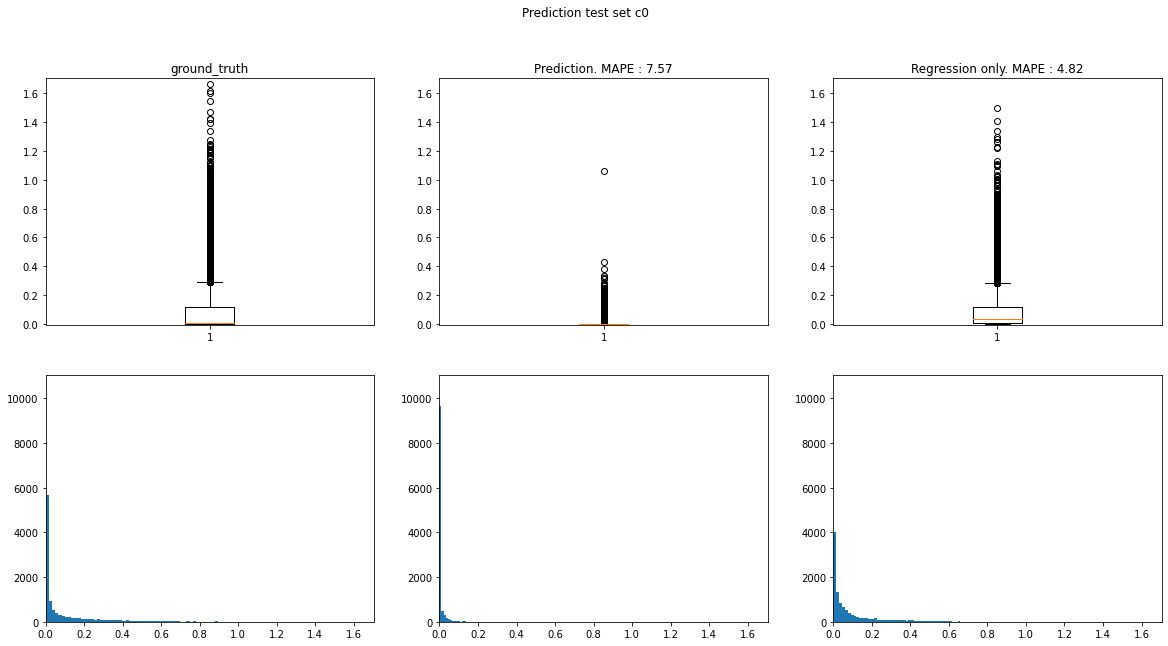

In [37]:
box_plot(prediction_x_test_c0, plot_title="Prediction test set c0")

-------------------------------------------
# cluster 1
-------------------------------------------

# Classification Model (raining or not)
source : https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

In [38]:
with tf.device("cpu"):
    history_cls_c1, model_cls_c1 = make_cls_model(
        Dense(128, activation="sigmoid",input_dim=x_train_c0.shape[1]),
        Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        last_activation="sigmoid",
        x=x_train_c1.values ,y=y_cls_train_c1,
        epochs=600,
        batch_size=64,
        learning_rate=0.001
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               12544     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 32)               

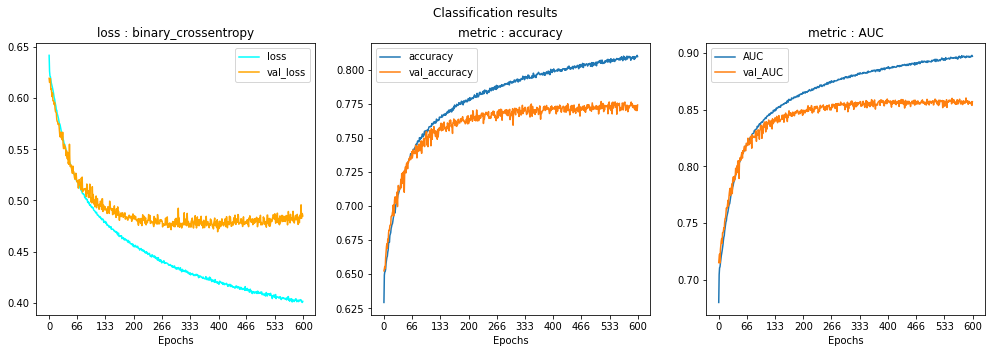

In [39]:
# Plot history
plot_history_cls(history_cls_c1, loss = "binary_crossentropy", key1 = 'accuracy', key2 = 'AUC')

# Regression Model (how much rain if > 0)
source : https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [40]:
# reshape x_train and x_test
# x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
with tf.device("cpu") :
    history_reg_c1, model_reg_c1 = make_reg_model(
        Dense(128, activation="sigmoid",input_dim=x_train_c0.shape[1]),
        Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(64, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        # Dropout(0.1),
        Dense(32, activation="relu"),
        last_activation=square_relu,
        x=x_train_c0.values ,y=y_reg_train_c0,
        epochs=600,
        batch_size=64,
        learning_rate=0.001
    )

Epoch 1/600
1321/1321 [==============================] - 3s 2ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0301 - val_mean_squared_error: 0.0302
Epoch 2/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0297 - val_mean_squared_error: 0.0298
Epoch 3/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0289 - val_mean_squared_error: 0.0291
Epoch 4/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0283 - val_mean_squared_error: 0.0284
Epoch 5/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0283 - val_mean_squared_error: 0.0284
Epoch 6/600
1321/1321 [==============================] - 2s 2ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0284 - val_mean_squared_error: 0.0285
Epoch 7/60

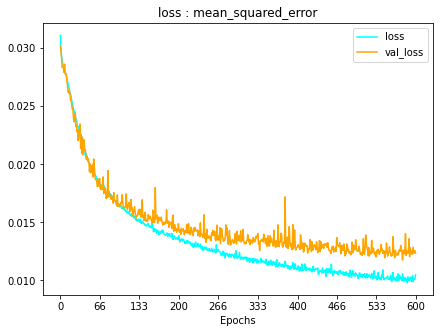

In [41]:
# Plot history
plot_history_reg(history_reg_c1, 'mean_squared_error')

# Compute MAPE on test set

## classification

In [42]:
y_cls_pred_c1 = model_cls_c1.predict(x_test_c1)

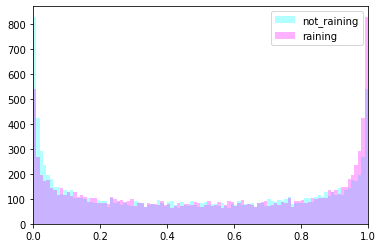

In [43]:
plt.hist(y_cls_pred_c1[:,0], color="cyan", alpha=0.3, bins=100, label="not_raining")
plt.hist(y_cls_pred_c1[:,1], color="magenta", alpha=0.3, bins=100, label="raining")
plt.xlim([0,1])
plt.legend()
plt.show()

In [44]:
y_cls_pred_bkp_c1 = np.array(y_cls_pred_c1)

In [45]:
y_cls_pred_c1 = np.array(y_cls_pred_bkp_c1)

In [46]:
cls_temp_c1 = y_cls_pred_c1[:,0] < y_cls_pred_c1[:,1]
y_cls_pred_c1 = np.array([0 if c else 1 for c in cls_temp_c1])

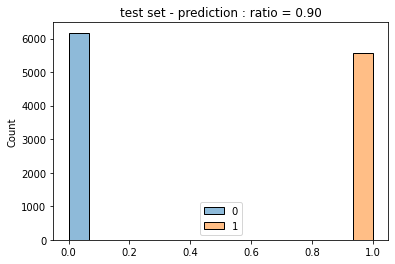

In [47]:
raining_ratio_pred_c1 = y_cls_pred_c1.sum()/(len(y_cls_pred_c1) - y_cls_pred_c1.sum())
plt.title("test set - prediction : ratio = {:.2f}".format(raining_ratio_pred_c1))
sns.histplot(x=y_cls_pred_c1,hue=y_cls_pred_c1)
plt.show()

## regression

In [48]:
y_reg_pred_c1 = model_reg_c1.predict(x_test_c1)

## merge

In [49]:
prediction_x_test_c1["reg_pred"] = y_reg_pred_c1
prediction_x_test_c1["cls_pred"] = y_cls_pred_c1
prediction_x_test_c1["Prediction"] = prediction_x_test_c1["reg_pred"] * prediction_x_test_c1["cls_pred"]

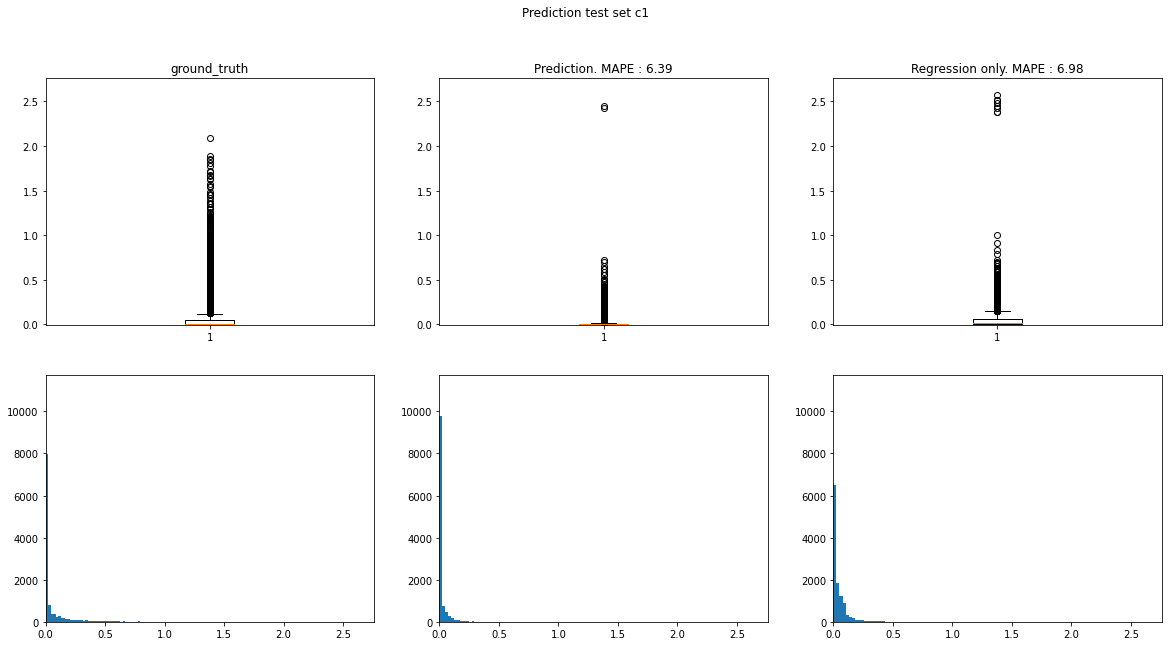

In [50]:
box_plot(prediction_x_test_c1, plot_title="Prediction test set c1")

-----------
# merge c0 and c1
-----------

In [51]:
prediction_x_test = pd.concat([prediction_x_test_c0, prediction_x_test_c1])

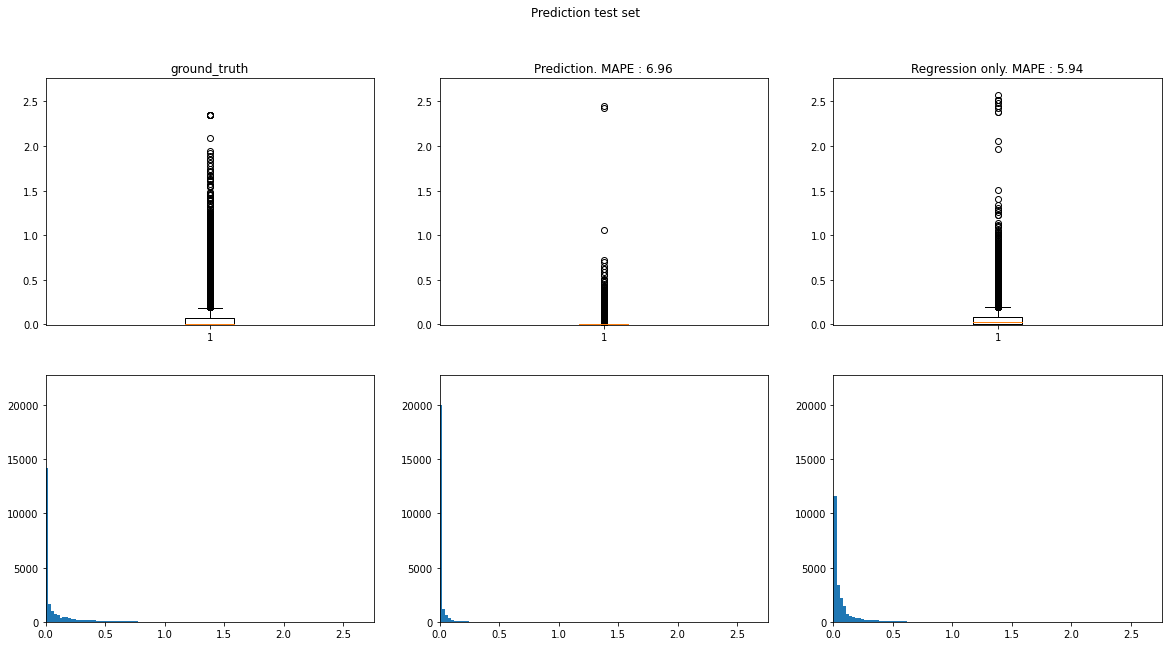

In [52]:
box_plot(prediction_x_test, plot_title="Prediction test set")

-------------------------------------------
# Make a submission
-------------------------------------------

In [53]:
test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final_by_day.zip")
# test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final.zip")

# split test set into c0 and c1

In [54]:
test_set["cluster"] = test_set["month"].apply(lambda x : 0 if x in cluster_month_0 else 1)
test_set_c0 = test_set[test_set["cluster"] == 0]
test_set_c1 = test_set[test_set["cluster"] == 1]

## create submission dataset

In [55]:
submission_c0 = pd.DataFrame(test_set_c0[["Id"]])
submission_c1 = pd.DataFrame(test_set_c1[["Id"]])

## get same columns as before for test_set

In [56]:
test_set_c0 = test_set_c0[columns]
test_set_c1 = test_set_c1[columns]

## normalize same way test_set

In [57]:
test_set_c0 = normalize(test_set_c0,normalization_infos)
test_set_c1 = normalize(test_set_c1,normalization_infos)

In [58]:
test_set_c0.head()

,altitude (m),latitude,longitude,month_cos,month_sin,current hour precipitations (kg/m^2),wind_direction_cos,wind_direction_sin,wind_speed (m/s),wind_component_u (m/s),...,3D_Arpege_isobar_600hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_600hpa_Geopotential (m^2/s^2),3D_Arpege_isobar_500hpa_Temperature (K),3D_Arpege_isobar_500hpa_RelavtiveHumidity (%),3D_Arpege_isobar_500hpa_WindSpeed (m/s),3D_Arpege_isobar_500hpa_WindDirection (deg),3D_Arpege_isobar_500hpa_WindComponentU (m/s),3D_Arpege_isobar_500hpa_WindComponentV (m/s),3D_Arpege_isobar_500hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_500hpa_Geopotential (m^2/s^2)
1,0.152632,0.75,0.833333,0.750000,0.933013,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.592835,0.987683,0.851050,0.243663,0.169768,0.688638,0.520906,0.601052,0.569387,0.989601
2,0.152632,0.75,0.833333,0.933013,0.250000,0.09375,0.335841,0.972284,0.096735,0.43423,...,0.538019,0.905300,0.271608,0.536040,0.349677,0.700741,0.613256,0.614223,0.542626,0.909959
5,0.152632,0.75,0.833333,0.750000,0.066987,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.649773,0.968288,0.742972,0.595791,0.202649,0.526871,0.446060,0.688499,0.581788,0.971317
7,0.152632,0.75,0.833333,0.750000,0.933013,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.604854,0.958982,0.704392,0.668309,0.241341,0.791664,0.558318,0.505129,0.561284,0.962043
8,0.152632,0.75,0.833333,0.500000,1.000000,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.529531,0.874801,0.482468,0.881668,0.346017,0.572446,0.526334,0.749904,0.529925,0.892868


## Predict test_set for submission

## classification

In [61]:
y_cls_pred_c0 = model_cls_c0.predict(test_set_c0)
y_cls_pred_c1 = model_cls_c1.predict(test_set_c1)

In [60]:
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# sns.histplot(x=y_cls_pred_c0[:,1], hue=y_cls_pred_c0[:,1])
# plt.subplot(1,2,2)
# sns.histplot(x=y_cls_pred_c1[:,1], hue=y_cls_pred_c1[:,1])
# plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f77d4cb73a0> (for post_execute):


KeyboardInterrupt: 

In [62]:
print(avg_raining_ratio_c0, avg_raining_ratio_c1)

1.800743099711916 1.1608066548298557


In [63]:
y_cls_pred_bkp_c0 = np.array(y_cls_pred_c0)
y_cls_pred_bkp_c1 = np.array(y_cls_pred_c1)

In [64]:
y_cls_pred_c0 = np.array(y_cls_pred_bkp_c0)
y_cls_pred_c1 = np.array(y_cls_pred_bkp_c1)

In [65]:
cls_temp_c0 = y_cls_pred_c0[:,0] < y_cls_pred_c0[:,1]
y_cls_pred_c0 = np.array([0 if c else 1 for c in cls_temp_c0])
cls_temp_c1 = y_cls_pred_c1[:,0] < y_cls_pred_c1[:,1]
y_cls_pred_c1 = np.array([0 if c else 1 for c in cls_temp_c1])

## regression

In [66]:
y_reg_pred_c0 = model_reg_c0.predict(test_set_c0)
y_reg_pred_c1 = model_reg_c1.predict(test_set_c1)

## fill in submission df

In [67]:
submission_c0["cls_pred"] = y_cls_pred_c0
submission_c0["reg_pred"] = y_reg_pred_c0

submission_c1["cls_pred"] = y_cls_pred_c1
submission_c1["reg_pred"] = y_reg_pred_c1

In [68]:
submission_c0["Prediction"] = submission_c0["cls_pred"] * submission_c0["reg_pred"]
submission_c1["Prediction"] = submission_c1["cls_pred"] * submission_c1["reg_pred"]

In [69]:
submission = pd.concat([submission_c0,submission_c1])
submission.head(25)

,Id,cls_pred,reg_pred,Prediction
1,14047002_10,1,0.015555,0.015555
2,14047002_100,0,0.378482,0.000000
5,14047002_103,0,0.000291,0.000000
7,14047002_105,0,0.014681,0.000000
8,14047002_106,1,0.043195,0.043195
9,14047002_107,0,0.388880,0.000000
11,14047002_109,0,0.051624,0.000000
12,14047002_11,0,0.066090,0.000000
17,14047002_114,0,0.269443,0.000000
18,14047002_115,1,0.183948,0.183948


In [70]:
submission[["Id","Prediction"]].to_csv("./submission_ann_clustered_reg_cls_extended.csv", index=False)

In [71]:
submission2 = submission.drop(["Prediction","cls_pred"], axis=1)
submission2.rename(columns={"reg_pred": "Prediction"}, inplace=True)

In [72]:
submission2.head()

,Id,Prediction
1,14047002_10,0.015555
2,14047002_100,0.378482
5,14047002_103,0.000291
7,14047002_105,0.014681
8,14047002_106,0.043195


In [73]:
submission2[["Id","Prediction"]].to_csv("./submission_ann_clustered_reg_extended.csv", index=False)